# Analyzing influence of part load operation

## Flowsheet and important parameters of heat pump

![flowsheet](./workshop/figures/heat_pump_full.svg)

### Previous model

| parameter description    | model location | model parameter | value | unit |
|:------------------------ |:-------------- |:--------------- | -----:|:---- |
| compressor efficiency    | compressor     | `eta_s`         |    80 | %    |
| heat delivered           | condenser      | `Q`             |   9.1 | kW   |
| working fluid            | 2              | `fluid`         |  R290 |      |
| evaporation temperature  |                | `T`             |     2 | °C   |
| condensation temperatre  | 4              | `T`             |    40 | °C   |

### Additional/updated information

| parameter description    | model location | model parameter | value | unit |
|:------------------------ |:-------------- |:--------------- | -----:|:---- |
| compressor efficiency    | compressor     | `eta_s`         |  67.5 | %    |
| ambient temperature      | 11             | `T`             |     7 | °C   |
| air outlet temperature   | 12             | `T`             | $T_{11}$ - 2 | °C   |
| water supply temperature | 22             | `T`             |    35 | °C   |
| water return temperature | 21             | `T`             |    30 | °C   |

## Build the model

### Setup and topology

In [18]:
from tespy.components import Condenser, HeatExchanger, CycleCloser, Compressor, Valve, Source, Sink
from tespy.connections import Connection, Ref
from tespy.networks import Network

wf = "R290"
nwk = Network(p_unit="bar", T_unit="C", iterinfo=False)

cp = Compressor("compressor")
ev = HeatExchanger("evaporator")
cd = Condenser("condenser")
va = Valve("expansion valve")
cc = CycleCloser("cycle closer")

so1 = Source("ambient air source")
si1 = Sink("ambient air sink")
so2 = Source("heating source")
si2 = Sink("heating sink")

c0 = Connection(va, "out1", cc, "in1", label="0")
c1 = Connection(cc, "out1", ev, "in2", label="1")
c2 = Connection(ev, "out2", cp, "in1", label="2")
c3 = Connection(cp, "out1", cd, "in1", label="3")
c4 = Connection(cd, "out1", va, "in1", label="4")

nwk.add_conns(c0, c1, c2, c3, c4)

c11 = Connection(so1, "out1", ev, "in1", label="11")
c12 = Connection(ev, "out1", si1, "in1", label="12")

c21 = Connection(so2, "out1", cd, "in2", label="21")
c22 = Connection(cd, "out2", si2, "in1", label="22")

nwk.add_conns(c11, c12, c21, c22)

### Component and process parameters

Compressor efficiency as found in first section

In [19]:
# connections
c2.set_attr(T=2)
c4.set_attr(T=40)

# components
Q_design = -9.1e3
cp.set_attr(eta_s=0.675)
cd.set_attr(Q=Q_design)

# connections
T_ambient_design = 7
c2.set_attr(fluid={wf: 1}, x=1.0)
c11.set_attr(fluid={"air": 1}, p=1.0, T=T_ambient_design)
c12.set_attr(T=Ref(c11, 1, -2))
c21.set_attr(fluid={"Water": 1}, p=3.0, T=30)
c22.set_attr(T=35)

# components
cd.set_attr(pr1=1, pr2=1)
ev.set_attr(pr1=1, pr2=1)

### Run and save results

In [20]:
nwk.solve("design")
nwk.print_results()


##### RESULTS (Valve) #####
+-----------------+----------+----------+
|                 |       pr |     zeta |
|-----------------+----------+----------|
| expansion valve | 3.68e-01 | 1.04e+11 |
+-----------------+----------+----------+
##### RESULTS (Condenser) #####
+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|           |         Q |       kA |   td_log |    ttd_u |    ttd_l |      pr1 |      pr2 |    zeta1 |    zeta2 |
|-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------|
| condenser | -9.10e+03 | 1.26e+03 | 7.21e+00 | 5.00e+00 | 1.00e+01 | 1.00e+00 | 1.00e+00 | 2.06e-05 | 0.00e+00 |
+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
##### RESULTS (HeatExchanger) #####
+------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|       

In [21]:
nwk.save("design-state")

### Assumptions for part load operation

Parameters follow lookup curves relative to design point value

- Compressor efficiency follows efficiency curve `eta_s_char`
- Evaporator heat transfer coefficient follows adjustment factor from `kA_char`, we cannot control evaporation temperature anymore
- Condenser heat transfer coefficient follows adjustment factor from `kA_char`, we cannot control condensation temperature anymore

In [22]:
cp.set_attr(design=["eta_s"], offdesign=["eta_s_char"])
cp.eta_s_char.char_func.extrapolate = True

ev.set_attr(offdesign=["kA_char"])
c2.set_attr(design=["T"])

cd.set_attr(offdesign=["kA_char"])
c4.set_attr(design=["T"])

### Solve part load model

In [23]:
nwk.solve("offdesign", design_path="design-state")
nwk.print_results()


##### RESULTS (Valve) #####
+-----------------+----------+----------+
|                 |       pr |     zeta |
|-----------------+----------+----------|
| expansion valve | 3.68e-01 | 1.04e+11 |
+-----------------+----------+----------+
##### RESULTS (Condenser) #####
+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|           |         Q |       kA |   td_log |    ttd_u |    ttd_l |      pr1 |      pr2 |    zeta1 |    zeta2 |
|-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------|
| condenser | -9.10e+03 | 1.26e+03 | 7.21e+00 | 5.00e+00 | 1.00e+01 | 1.00e+00 | 1.00e+00 | 4.12e-05 | 3.77e-07 |
+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
##### RESULTS (HeatExchanger) #####
+------------+-----------+----------+----------+----------+----------+----------+----------+-----------+----------+
|      

### Set up ambient temperature and heat production range

- Ambient temperature from -10 °C to 20 °C
- Heat production range from 50 % of nominal production to nominal production

In [24]:
import numpy as np
import pandas as pd


heat_range = np.linspace(0.5, 1.0, 11) * Q_design
temperature_range = np.arange(-10, 21)

results = {}

### Run loop

- For every temperature run a simulation at variable heat production
- Save the COP, the compressor power, condensation and evaporation temperature

In [25]:
init_path = None
for temperature in temperature_range:
    results[temperature] = pd.DataFrame(index=heat_range, columns=["COP", "compressor-power", "T-evaporation", "T-condensation"])
    c11.set_attr(T=temperature)
    for heat in heat_range[::-1]:
        cd.set_attr(Q=heat)
        if heat == heat_range[-1]:
            nwk.solve("offdesign", design_path="design-state", init_path=init_path)
            nwk.save("tmp")
            init_path = "tmp"
        else:
            nwk.solve("offdesign", design_path="design-state")

        results[temperature].loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val
        results[temperature].loc[heat, "compressor-power"] = cp.P.val
        results[temperature].loc[heat, "T-evaporation"] = c2.T.val
        results[temperature].loc[heat, "T-condensation"] = c4.T.val

In [26]:
results

{-10:               COP compressor-power T-evaporation T-condensation
 -4550.0  2.898691      1569.674247    -13.689407      37.950581
 -5005.0  2.955845      1693.255252    -13.804999      38.169359
 -5460.0   3.01465      1811.155404    -13.911813      38.373757
 -5915.0  3.072223      1925.316155    -14.014618      38.587674
 -6370.0  3.127095      2037.034102    -14.121594      38.809703
 -6825.0   3.17855      2147.205517    -14.228165      39.018567
 -7280.0  3.225298      2257.155496    -14.328759      39.215555
 -7735.0  3.265396       2368.77858    -14.421419      39.426661
 -8190.0  3.297071       2484.02299    -14.517454      39.642939
 -8645.0  3.319644      2604.194964    -14.611464      39.851052
 -9100.0    3.3296      2733.061404    -14.697881      40.052193,
 -9:               COP compressor-power T-evaporation T-condensation
 -4550.0  2.956644      1538.907102    -12.704277      37.946529
 -5005.0  3.015471      1659.773811    -12.819871      38.164886
 -5460.0  3.075

### Plot the COP and compressor power

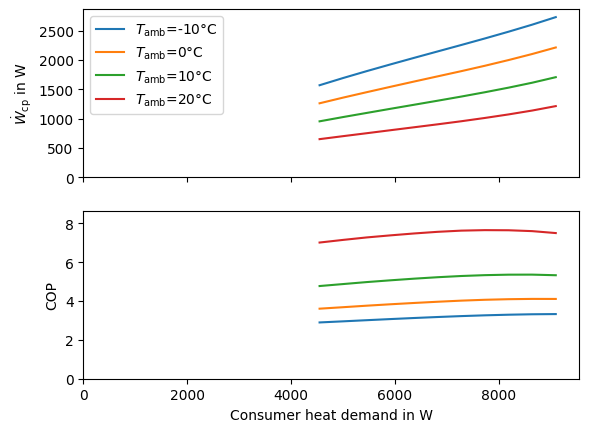

In [27]:
from matplotlib import pyplot as plt


power_max = 0
COP_max = 0

fig, ax = plt.subplots(2, sharex=True)

for temp in temperature_range[::10]:

    ax[0].plot(np.abs(results[temp].index), results[temp]["compressor-power"], label="$T_\\mathrm{amb}$=" + str(temp) + "°C")
    ax[1].plot(np.abs(results[temp].index), results[temp]["COP"])
    COP_max = max(results[temp]["COP"].max(), COP_max)
    power_max = max(results[temp]["compressor-power"].max(), power_max)

ax[0].legend()
ax[0].set_ylabel("$\dot W_\\mathrm{cp}$ in W")
ax[0].set_ylim([0, power_max * 1.05])
ax[1].set_ylabel("COP")
ax[1].set_ylim([0, COP_max + 1])
ax[1].set_xlim([0, np.abs(heat_range).max() * 1.05])
_ = ax[1].set_xlabel("Consumer heat demand in W")

### Linearize compressor power vs. heat production curve

In [28]:
def least_squares(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    slope, offset = np.linalg.lstsq(A, y, rcond=None)[0]
    return slope, offset

### TESPy results

In [29]:
x = -results[T_ambient_design].index.values.astype(float)
y = results[T_ambient_design]["compressor-power"].values.astype(float)
yy_tespy = y

### Linearized

In [30]:
slope, offset = least_squares(x, y)
yy_offset = offset + slope * x

### Carnot COP method with constant efficiency factor

In [31]:
COP_c_simple = (
    (results[T_ambient_design]["T-condensation"] + 273.15) /
    (results[T_ambient_design]["T-condensation"] - results[T_ambient_design]["T-evaporation"])
)
eta_c_simple = 4.9 / COP_c_simple.loc[Q_design]
eta_c_simple

0.594603225294763

### Plot the results

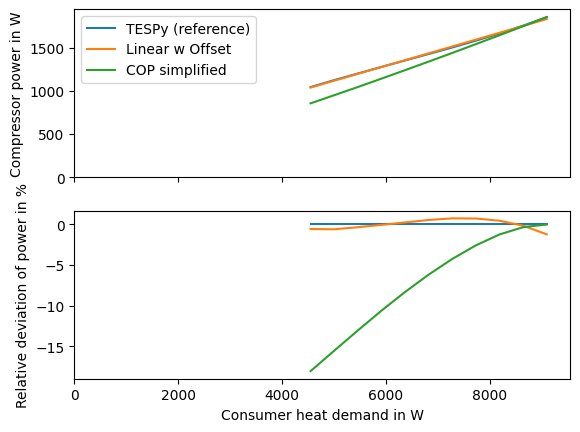

In [32]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(x, yy_tespy, label="TESPy (reference)")
ax[0].plot(x, yy_offset, label="Linear w Offset")
ax[0].plot(x, x / (COP_c_simple * eta_c_simple), label="COP simplified")

ax[1].plot(x, (yy_tespy - yy_tespy) / yy_tespy * 100)
ax[1].plot(x, (yy_offset - yy_tespy) / yy_tespy * 100)
ax[1].plot(x, (x / (COP_c_simple * eta_c_simple) - yy_tespy) / yy_tespy * 100)

ax[0].legend()
ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, y.max() * 1.05])
ax[1].set_ylabel("Relative deviation of power in %")
ax[1].set_xlim([0, x.max() * 1.05])
_ = ax[1].set_xlabel("Consumer heat demand in W")

### Plot the linearized results

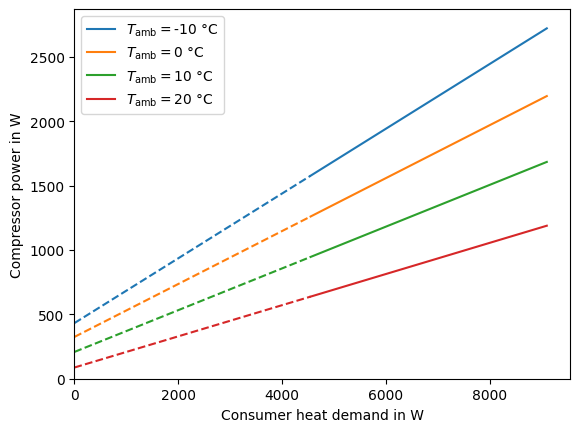

In [33]:
fig, ax = plt.subplots(1)

for temp in temperature_range[::10]:

    x = -results[temp].index.values.astype(float)
    y = results[temp]["compressor-power"].values.astype(float)
    slope, offset = least_squares(x, y)
    p = ax.plot(x, slope * x + offset, label="$T_\\mathrm{amb}=$" + str(temp) + " °C")  # get line information to extract color
    ax.plot([0, x.min()], slope * np.array([0, x.min()]) + offset, "--", color=p[0].get_color())
    power_max = max(results[temp]["compressor-power"].max(), power_max)

ax.set_ylim([0, power_max * 1.05])
ax.set_ylabel("Compressor power in W")
ax.set_xlim([0, x.max() * 1.05])
ax.legend()
_ = ax.set_xlabel("Consumer heat demand in W")

### Export results to oemof-solph

oemof-solph needs a consumer heat demand as function of electricity consumption

In [34]:
export_df = pd.DataFrame(index=temperature_range, columns=["slope", "offset"])

for key, data in results.items():
    y = -data.index.values.astype(float)
    x = data["compressor-power"].values.astype(float)
    export_df.loc[key] = least_squares(x, y)

export_df.to_csv("coefficients-offset-converter.csv")